# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper


helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

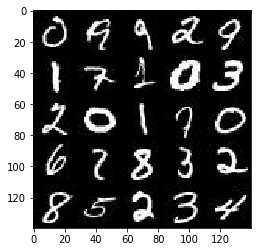

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

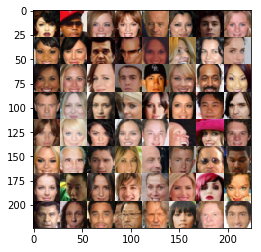

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], 
                                name="input_real")
    z_dim = tf.placeholder(tf.float32, (None, z_dim), name="fake_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate") 

    return input_real, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Convert 28x28x3 into 12x14x64 Convolution Step
        layer_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same', 
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        # Convert 14x14x64 into 7x7x128 Convolution Step
        layer_2 = tf.layers.conv2d(layer_1,128,5,strides=2,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        bn_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        # Convert 7x7x128 into 7x7x256 Convolution Step
        layer_3 = tf.layers.conv2d(layer_2,256,5,strides=1,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.1))
        bn_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        # Convert 7x7x256 into 7x7x512 Convolution Step 
        layer_4 = tf.layers.conv2d(layer_3,512,5,strides=1,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.1))
        bn_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        
        dimensions = layer_4.get_shape().as_list()
        
        # Flatten
        flat = tf.reshape(layer_4, (-1,dimensions[1]*dimensions[2]*dimensions[3]))
        logits= tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    

    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Stack --- Reshape and Normalization
        stack = tf.layers.dense(z, 7*7*512)
        alpha = 0.2
        stack_reshaped = tf.reshape(stack,(-1,7,7,512))
        stack_normalized = tf.layers.batch_normalization(stack_reshaped, training=is_train)
        stack_normalized = tf.maximum(alpha * stack_normalized, stack_normalized)
        
        # Deconvolution 7x7x512 into 14x14x256
        deconv_1 = tf.layers.conv2d_transpose(stack_normalized, 256, 5, strides=2, padding='same',
                                              kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_1 = tf.layers.batch_normalization(deconv_1, training=is_train)
        deconv_1 = tf.maximum(alpha * deconv_1, deconv_1)
        
        # Deconvolution 14x14x256 into 28x28x128
        deconv_2 = tf.layers.conv2d_transpose(deconv_1,128,5,strides=2,padding='same',
                                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        deconv_2 = tf.maximum(alpha * deconv_2, deconv_2)
        
        # Deconvolution 28x28x128 into 28x28x64
        deconv_3 = tf.layers.conv2d_transpose(deconv_2,64,5,strides=1,padding='same',
                                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        deconv_3 = tf.maximum(alpha * deconv_3, deconv_3)
        
        #output layer
        logits = tf.layers.conv2d_transpose(deconv_3, out_channel_dim, 5, strides=1, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Update Weights & Bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimise
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
                
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2

                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_ph: learning_rate})

                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_ph: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{} ...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ... Discriminator Loss: 1.4107... Generator Loss: 0.6897
Epoch 1/2 ... Discriminator Loss: 1.3537... Generator Loss: 0.6278
Epoch 1/2 ... Discriminator Loss: 1.1640... Generator Loss: 0.9983
Epoch 1/2 ... Discriminator Loss: 1.0600... Generator Loss: 1.2100
Epoch 1/2 ... Discriminator Loss: 1.3440... Generator Loss: 0.7589
Epoch 1/2 ... Discriminator Loss: 1.2702... Generator Loss: 0.9007
Epoch 1/2 ... Discriminator Loss: 1.5724... Generator Loss: 0.5102
Epoch 1/2 ... Discriminator Loss: 1.3851... Generator Loss: 0.7797
Epoch 1/2 ... Discriminator Loss: 1.4898... Generator Loss: 0.7556
Epoch 1/2 ... Discriminator Loss: 1.3641... Generator Loss: 0.7327


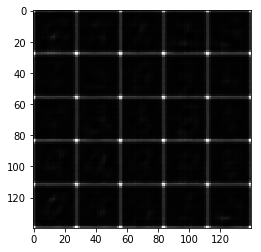

Epoch 1/2 ... Discriminator Loss: 1.4376... Generator Loss: 0.9673
Epoch 1/2 ... Discriminator Loss: 1.3729... Generator Loss: 0.8279
Epoch 1/2 ... Discriminator Loss: 1.2137... Generator Loss: 0.8775
Epoch 1/2 ... Discriminator Loss: 1.3423... Generator Loss: 0.7639
Epoch 1/2 ... Discriminator Loss: 1.4126... Generator Loss: 0.6949
Epoch 1/2 ... Discriminator Loss: 1.6166... Generator Loss: 0.6704
Epoch 1/2 ... Discriminator Loss: 1.2204... Generator Loss: 0.8113
Epoch 1/2 ... Discriminator Loss: 1.3961... Generator Loss: 0.7714
Epoch 1/2 ... Discriminator Loss: 1.3063... Generator Loss: 0.8279
Epoch 1/2 ... Discriminator Loss: 1.3780... Generator Loss: 0.7265


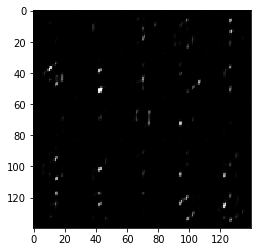

Epoch 1/2 ... Discriminator Loss: 1.1158... Generator Loss: 1.1495
Epoch 1/2 ... Discriminator Loss: 1.3298... Generator Loss: 0.9070
Epoch 1/2 ... Discriminator Loss: 1.4998... Generator Loss: 0.8936
Epoch 1/2 ... Discriminator Loss: 1.2874... Generator Loss: 0.9665
Epoch 1/2 ... Discriminator Loss: 1.1079... Generator Loss: 0.9279
Epoch 1/2 ... Discriminator Loss: 1.2540... Generator Loss: 1.1001
Epoch 1/2 ... Discriminator Loss: 1.1561... Generator Loss: 1.0024
Epoch 1/2 ... Discriminator Loss: 1.2206... Generator Loss: 0.9205
Epoch 1/2 ... Discriminator Loss: 1.2763... Generator Loss: 0.6711
Epoch 1/2 ... Discriminator Loss: 1.3574... Generator Loss: 0.7763


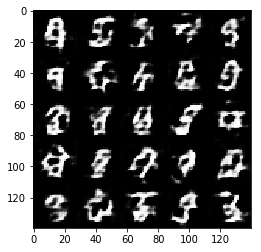

Epoch 1/2 ... Discriminator Loss: 1.2727... Generator Loss: 0.6892
Epoch 1/2 ... Discriminator Loss: 1.2105... Generator Loss: 1.1309
Epoch 1/2 ... Discriminator Loss: 1.1058... Generator Loss: 1.1158
Epoch 1/2 ... Discriminator Loss: 1.4345... Generator Loss: 0.5727
Epoch 1/2 ... Discriminator Loss: 1.0775... Generator Loss: 0.9678
Epoch 1/2 ... Discriminator Loss: 1.1684... Generator Loss: 1.0075
Epoch 1/2 ... Discriminator Loss: 1.1685... Generator Loss: 1.3809
Epoch 1/2 ... Discriminator Loss: 0.9211... Generator Loss: 1.1603
Epoch 1/2 ... Discriminator Loss: 1.3307... Generator Loss: 2.0561
Epoch 1/2 ... Discriminator Loss: 1.2891... Generator Loss: 0.9015


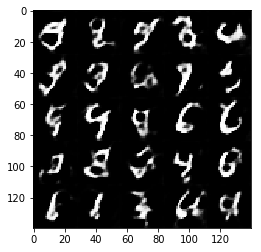

Epoch 1/2 ... Discriminator Loss: 1.1605... Generator Loss: 0.9836
Epoch 1/2 ... Discriminator Loss: 1.2027... Generator Loss: 0.7395
Epoch 1/2 ... Discriminator Loss: 1.2739... Generator Loss: 1.2367
Epoch 1/2 ... Discriminator Loss: 1.4785... Generator Loss: 0.7430
Epoch 1/2 ... Discriminator Loss: 1.3082... Generator Loss: 1.0056
Epoch 1/2 ... Discriminator Loss: 1.2325... Generator Loss: 1.1046
Epoch 1/2 ... Discriminator Loss: 1.1327... Generator Loss: 1.1403
Epoch 1/2 ... Discriminator Loss: 1.2198... Generator Loss: 0.8573
Epoch 1/2 ... Discriminator Loss: 1.2302... Generator Loss: 0.8730
Epoch 1/2 ... Discriminator Loss: 1.3132... Generator Loss: 0.7658


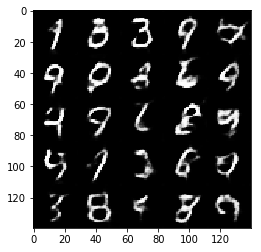

Epoch 1/2 ... Discriminator Loss: 1.1771... Generator Loss: 1.0996
Epoch 1/2 ... Discriminator Loss: 1.2375... Generator Loss: 0.9638
Epoch 1/2 ... Discriminator Loss: 1.2159... Generator Loss: 0.9239
Epoch 1/2 ... Discriminator Loss: 1.1768... Generator Loss: 0.9039
Epoch 1/2 ... Discriminator Loss: 1.2818... Generator Loss: 1.2179
Epoch 1/2 ... Discriminator Loss: 1.2214... Generator Loss: 0.8717
Epoch 1/2 ... Discriminator Loss: 1.3569... Generator Loss: 0.6740
Epoch 1/2 ... Discriminator Loss: 1.4141... Generator Loss: 0.6485
Epoch 1/2 ... Discriminator Loss: 1.2871... Generator Loss: 0.8075
Epoch 1/2 ... Discriminator Loss: 1.2322... Generator Loss: 0.8730


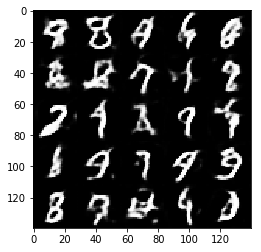

Epoch 1/2 ... Discriminator Loss: 1.2990... Generator Loss: 0.7773
Epoch 1/2 ... Discriminator Loss: 1.2552... Generator Loss: 0.7295
Epoch 1/2 ... Discriminator Loss: 1.3520... Generator Loss: 0.8249
Epoch 1/2 ... Discriminator Loss: 1.2470... Generator Loss: 0.9196
Epoch 1/2 ... Discriminator Loss: 1.2645... Generator Loss: 0.7990
Epoch 1/2 ... Discriminator Loss: 1.2320... Generator Loss: 0.8273
Epoch 1/2 ... Discriminator Loss: 1.3002... Generator Loss: 0.7283
Epoch 1/2 ... Discriminator Loss: 1.3618... Generator Loss: 0.7149
Epoch 1/2 ... Discriminator Loss: 1.1968... Generator Loss: 0.8337
Epoch 1/2 ... Discriminator Loss: 1.2344... Generator Loss: 0.9351


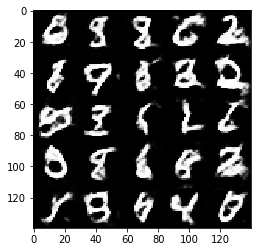

Epoch 1/2 ... Discriminator Loss: 1.2755... Generator Loss: 0.7877
Epoch 1/2 ... Discriminator Loss: 1.2642... Generator Loss: 0.9277
Epoch 1/2 ... Discriminator Loss: 1.3293... Generator Loss: 0.8587
Epoch 1/2 ... Discriminator Loss: 1.2713... Generator Loss: 0.8291
Epoch 1/2 ... Discriminator Loss: 1.2260... Generator Loss: 0.8931
Epoch 1/2 ... Discriminator Loss: 1.2799... Generator Loss: 0.9247
Epoch 1/2 ... Discriminator Loss: 1.1718... Generator Loss: 1.0767
Epoch 1/2 ... Discriminator Loss: 1.1492... Generator Loss: 1.0099
Epoch 1/2 ... Discriminator Loss: 1.2519... Generator Loss: 1.0488
Epoch 1/2 ... Discriminator Loss: 1.1626... Generator Loss: 0.9025


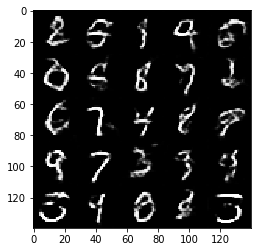

Epoch 1/2 ... Discriminator Loss: 1.2837... Generator Loss: 1.2984
Epoch 1/2 ... Discriminator Loss: 1.2189... Generator Loss: 1.1240
Epoch 1/2 ... Discriminator Loss: 1.1357... Generator Loss: 1.0000
Epoch 1/2 ... Discriminator Loss: 1.2883... Generator Loss: 0.9248
Epoch 1/2 ... Discriminator Loss: 1.1455... Generator Loss: 0.9198
Epoch 1/2 ... Discriminator Loss: 1.2737... Generator Loss: 0.7788
Epoch 1/2 ... Discriminator Loss: 1.3025... Generator Loss: 0.9052
Epoch 1/2 ... Discriminator Loss: 1.2640... Generator Loss: 0.8358
Epoch 1/2 ... Discriminator Loss: 1.2323... Generator Loss: 0.8250
Epoch 1/2 ... Discriminator Loss: 1.1433... Generator Loss: 0.9613


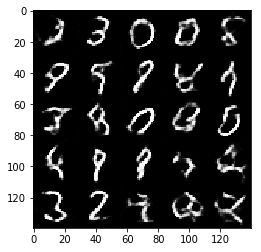

Epoch 1/2 ... Discriminator Loss: 1.2133... Generator Loss: 0.8442
Epoch 1/2 ... Discriminator Loss: 1.2293... Generator Loss: 1.0204
Epoch 1/2 ... Discriminator Loss: 1.2294... Generator Loss: 1.1713
Epoch 2/2 ... Discriminator Loss: 1.1255... Generator Loss: 1.2832
Epoch 2/2 ... Discriminator Loss: 1.3533... Generator Loss: 0.8510
Epoch 2/2 ... Discriminator Loss: 1.1439... Generator Loss: 1.0344
Epoch 2/2 ... Discriminator Loss: 1.1527... Generator Loss: 1.0643
Epoch 2/2 ... Discriminator Loss: 1.1766... Generator Loss: 0.9490
Epoch 2/2 ... Discriminator Loss: 1.1875... Generator Loss: 1.0573
Epoch 2/2 ... Discriminator Loss: 1.3036... Generator Loss: 0.8383


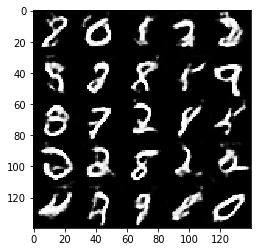

Epoch 2/2 ... Discriminator Loss: 1.2816... Generator Loss: 0.9049
Epoch 2/2 ... Discriminator Loss: 1.2428... Generator Loss: 0.9218
Epoch 2/2 ... Discriminator Loss: 1.3499... Generator Loss: 1.1228
Epoch 2/2 ... Discriminator Loss: 1.2980... Generator Loss: 0.7816
Epoch 2/2 ... Discriminator Loss: 1.2027... Generator Loss: 0.9550
Epoch 2/2 ... Discriminator Loss: 1.1926... Generator Loss: 0.9209
Epoch 2/2 ... Discriminator Loss: 1.1933... Generator Loss: 1.0550
Epoch 2/2 ... Discriminator Loss: 1.2601... Generator Loss: 0.8385
Epoch 2/2 ... Discriminator Loss: 1.2191... Generator Loss: 0.8571
Epoch 2/2 ... Discriminator Loss: 1.2150... Generator Loss: 1.0220


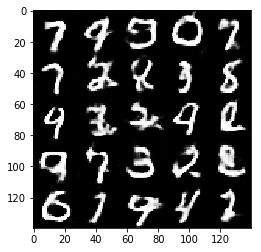

Epoch 2/2 ... Discriminator Loss: 1.1839... Generator Loss: 0.9314
Epoch 2/2 ... Discriminator Loss: 1.2405... Generator Loss: 1.1852
Epoch 2/2 ... Discriminator Loss: 1.1756... Generator Loss: 1.0761
Epoch 2/2 ... Discriminator Loss: 1.2844... Generator Loss: 0.7793
Epoch 2/2 ... Discriminator Loss: 1.2108... Generator Loss: 1.0767
Epoch 2/2 ... Discriminator Loss: 1.3730... Generator Loss: 0.7702
Epoch 2/2 ... Discriminator Loss: 1.2410... Generator Loss: 0.9546
Epoch 2/2 ... Discriminator Loss: 1.2412... Generator Loss: 0.9097
Epoch 2/2 ... Discriminator Loss: 1.1903... Generator Loss: 0.9522
Epoch 2/2 ... Discriminator Loss: 1.2286... Generator Loss: 0.9970


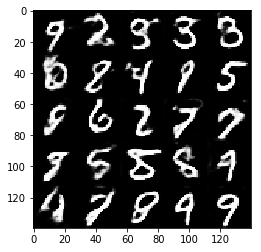

Epoch 2/2 ... Discriminator Loss: 1.1470... Generator Loss: 0.9821
Epoch 2/2 ... Discriminator Loss: 1.1882... Generator Loss: 1.2076
Epoch 2/2 ... Discriminator Loss: 1.3210... Generator Loss: 0.7715
Epoch 2/2 ... Discriminator Loss: 1.2662... Generator Loss: 1.0125
Epoch 2/2 ... Discriminator Loss: 1.2068... Generator Loss: 0.7564
Epoch 2/2 ... Discriminator Loss: 1.3196... Generator Loss: 1.0581
Epoch 2/2 ... Discriminator Loss: 1.1565... Generator Loss: 1.0227
Epoch 2/2 ... Discriminator Loss: 1.2073... Generator Loss: 0.9056
Epoch 2/2 ... Discriminator Loss: 1.1916... Generator Loss: 0.9619
Epoch 2/2 ... Discriminator Loss: 1.1862... Generator Loss: 0.8055


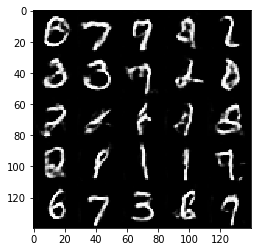

Epoch 2/2 ... Discriminator Loss: 1.2546... Generator Loss: 1.0985
Epoch 2/2 ... Discriminator Loss: 1.2610... Generator Loss: 0.8324
Epoch 2/2 ... Discriminator Loss: 1.2385... Generator Loss: 1.0878
Epoch 2/2 ... Discriminator Loss: 1.2349... Generator Loss: 0.9233
Epoch 2/2 ... Discriminator Loss: 1.1897... Generator Loss: 0.9592
Epoch 2/2 ... Discriminator Loss: 1.2759... Generator Loss: 0.9380
Epoch 2/2 ... Discriminator Loss: 1.1631... Generator Loss: 0.9111
Epoch 2/2 ... Discriminator Loss: 1.2168... Generator Loss: 0.9540
Epoch 2/2 ... Discriminator Loss: 1.3232... Generator Loss: 0.9998
Epoch 2/2 ... Discriminator Loss: 1.1317... Generator Loss: 1.1394


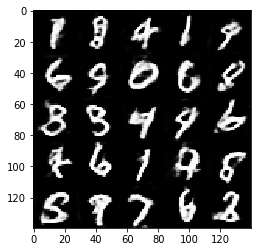

Epoch 2/2 ... Discriminator Loss: 1.2803... Generator Loss: 1.1004
Epoch 2/2 ... Discriminator Loss: 1.3000... Generator Loss: 0.9974
Epoch 2/2 ... Discriminator Loss: 1.1983... Generator Loss: 0.8916
Epoch 2/2 ... Discriminator Loss: 1.3086... Generator Loss: 1.0462
Epoch 2/2 ... Discriminator Loss: 1.3012... Generator Loss: 0.9319
Epoch 2/2 ... Discriminator Loss: 1.3408... Generator Loss: 1.0398
Epoch 2/2 ... Discriminator Loss: 1.2244... Generator Loss: 0.9886
Epoch 2/2 ... Discriminator Loss: 1.1795... Generator Loss: 1.1399
Epoch 2/2 ... Discriminator Loss: 1.1876... Generator Loss: 1.0047
Epoch 2/2 ... Discriminator Loss: 1.2151... Generator Loss: 0.8617


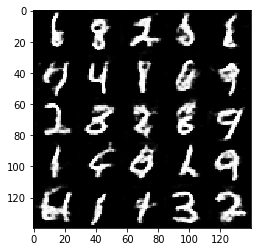

Epoch 2/2 ... Discriminator Loss: 1.2777... Generator Loss: 0.7534
Epoch 2/2 ... Discriminator Loss: 1.2323... Generator Loss: 1.1745
Epoch 2/2 ... Discriminator Loss: 1.2305... Generator Loss: 0.9431
Epoch 2/2 ... Discriminator Loss: 1.2046... Generator Loss: 1.0075
Epoch 2/2 ... Discriminator Loss: 1.2142... Generator Loss: 0.8696
Epoch 2/2 ... Discriminator Loss: 1.1724... Generator Loss: 0.8810
Epoch 2/2 ... Discriminator Loss: 1.2342... Generator Loss: 1.1215
Epoch 2/2 ... Discriminator Loss: 1.1480... Generator Loss: 0.9983
Epoch 2/2 ... Discriminator Loss: 1.2077... Generator Loss: 1.0400
Epoch 2/2 ... Discriminator Loss: 1.2287... Generator Loss: 1.2963


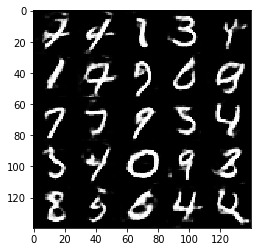

Epoch 2/2 ... Discriminator Loss: 1.2154... Generator Loss: 0.8652
Epoch 2/2 ... Discriminator Loss: 1.2472... Generator Loss: 0.8308
Epoch 2/2 ... Discriminator Loss: 1.2613... Generator Loss: 0.9362
Epoch 2/2 ... Discriminator Loss: 1.2606... Generator Loss: 0.9404
Epoch 2/2 ... Discriminator Loss: 1.2503... Generator Loss: 0.9719
Epoch 2/2 ... Discriminator Loss: 1.2056... Generator Loss: 0.9209
Epoch 2/2 ... Discriminator Loss: 1.1924... Generator Loss: 0.8841
Epoch 2/2 ... Discriminator Loss: 1.1791... Generator Loss: 0.9378
Epoch 2/2 ... Discriminator Loss: 1.3456... Generator Loss: 0.6826
Epoch 2/2 ... Discriminator Loss: 1.3059... Generator Loss: 0.7149


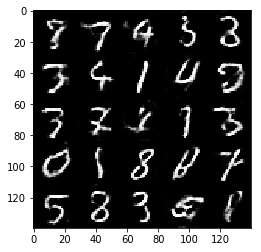

Epoch 2/2 ... Discriminator Loss: 1.1629... Generator Loss: 1.0061
Epoch 2/2 ... Discriminator Loss: 1.2175... Generator Loss: 0.9364
Epoch 2/2 ... Discriminator Loss: 1.3840... Generator Loss: 0.6695
Epoch 2/2 ... Discriminator Loss: 1.2357... Generator Loss: 0.8594
Epoch 2/2 ... Discriminator Loss: 1.1772... Generator Loss: 0.9222
Epoch 2/2 ... Discriminator Loss: 1.3423... Generator Loss: 0.9328
Epoch 2/2 ... Discriminator Loss: 1.2764... Generator Loss: 0.9890
Epoch 2/2 ... Discriminator Loss: 1.2582... Generator Loss: 0.7389
Epoch 2/2 ... Discriminator Loss: 1.2540... Generator Loss: 0.8443
Epoch 2/2 ... Discriminator Loss: 1.3033... Generator Loss: 0.9162


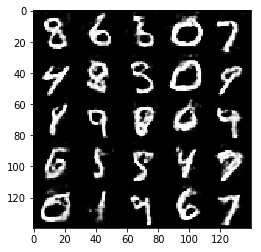

Epoch 2/2 ... Discriminator Loss: 1.1654... Generator Loss: 0.9642
Epoch 2/2 ... Discriminator Loss: 1.2700... Generator Loss: 0.9256
Epoch 2/2 ... Discriminator Loss: 1.2011... Generator Loss: 0.9166
Epoch 2/2 ... Discriminator Loss: 1.3079... Generator Loss: 0.8022
Epoch 2/2 ... Discriminator Loss: 1.2273... Generator Loss: 1.0113
Epoch 2/2 ... Discriminator Loss: 1.2031... Generator Loss: 1.1075
Epoch 2/2 ... Discriminator Loss: 1.2680... Generator Loss: 0.8876


In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ... Discriminator Loss: 1.0025... Generator Loss: 0.8788
Epoch 1/1 ... Discriminator Loss: 1.0432... Generator Loss: 0.9963
Epoch 1/1 ... Discriminator Loss: 0.9706... Generator Loss: 1.1940
Epoch 1/1 ... Discriminator Loss: 1.6475... Generator Loss: 0.8124
Epoch 1/1 ... Discriminator Loss: 1.1683... Generator Loss: 1.2019
Epoch 1/1 ... Discriminator Loss: 0.9764... Generator Loss: 1.1985
Epoch 1/1 ... Discriminator Loss: 1.1302... Generator Loss: 1.0091
Epoch 1/1 ... Discriminator Loss: 1.2798... Generator Loss: 0.9348
Epoch 1/1 ... Discriminator Loss: 1.4460... Generator Loss: 0.8051
Epoch 1/1 ... Discriminator Loss: 1.5006... Generator Loss: 0.6549


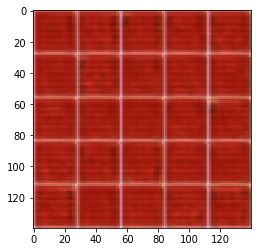

Epoch 1/1 ... Discriminator Loss: 1.3179... Generator Loss: 0.8943
Epoch 1/1 ... Discriminator Loss: 1.3372... Generator Loss: 0.9367
Epoch 1/1 ... Discriminator Loss: 1.4335... Generator Loss: 0.7329
Epoch 1/1 ... Discriminator Loss: 1.2477... Generator Loss: 0.8222
Epoch 1/1 ... Discriminator Loss: 2.0423... Generator Loss: 0.5230
Epoch 1/1 ... Discriminator Loss: 1.3770... Generator Loss: 0.8019
Epoch 1/1 ... Discriminator Loss: 1.3192... Generator Loss: 0.8408
Epoch 1/1 ... Discriminator Loss: 1.1645... Generator Loss: 1.0652
Epoch 1/1 ... Discriminator Loss: 1.3991... Generator Loss: 0.7125
Epoch 1/1 ... Discriminator Loss: 1.6367... Generator Loss: 0.7017


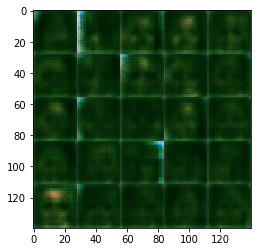

Epoch 1/1 ... Discriminator Loss: 1.3505... Generator Loss: 0.9053
Epoch 1/1 ... Discriminator Loss: 1.0863... Generator Loss: 1.0514
Epoch 1/1 ... Discriminator Loss: 1.3357... Generator Loss: 0.8342
Epoch 1/1 ... Discriminator Loss: 1.4235... Generator Loss: 0.7576
Epoch 1/1 ... Discriminator Loss: 1.3942... Generator Loss: 0.7089
Epoch 1/1 ... Discriminator Loss: 1.3041... Generator Loss: 0.8293
Epoch 1/1 ... Discriminator Loss: 1.4840... Generator Loss: 0.8026
Epoch 1/1 ... Discriminator Loss: 1.4101... Generator Loss: 0.7166
Epoch 1/1 ... Discriminator Loss: 1.3826... Generator Loss: 0.7132
Epoch 1/1 ... Discriminator Loss: 1.2533... Generator Loss: 0.9768


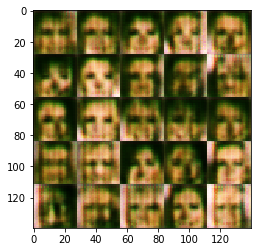

Epoch 1/1 ... Discriminator Loss: 1.3971... Generator Loss: 0.8032
Epoch 1/1 ... Discriminator Loss: 1.2450... Generator Loss: 0.8498
Epoch 1/1 ... Discriminator Loss: 1.3144... Generator Loss: 0.8274
Epoch 1/1 ... Discriminator Loss: 1.4082... Generator Loss: 0.7609
Epoch 1/1 ... Discriminator Loss: 1.5372... Generator Loss: 0.7197
Epoch 1/1 ... Discriminator Loss: 1.4182... Generator Loss: 0.8357
Epoch 1/1 ... Discriminator Loss: 1.3607... Generator Loss: 0.8046
Epoch 1/1 ... Discriminator Loss: 1.3089... Generator Loss: 0.8589
Epoch 1/1 ... Discriminator Loss: 1.4586... Generator Loss: 0.8466
Epoch 1/1 ... Discriminator Loss: 1.2649... Generator Loss: 0.9116


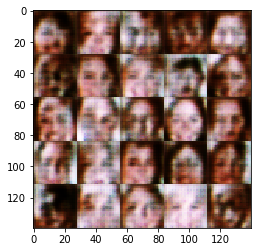

Epoch 1/1 ... Discriminator Loss: 1.3812... Generator Loss: 0.7464
Epoch 1/1 ... Discriminator Loss: 1.3391... Generator Loss: 0.8322
Epoch 1/1 ... Discriminator Loss: 1.3164... Generator Loss: 0.8576
Epoch 1/1 ... Discriminator Loss: 1.2350... Generator Loss: 0.8462
Epoch 1/1 ... Discriminator Loss: 1.2647... Generator Loss: 0.9046
Epoch 1/1 ... Discriminator Loss: 1.3880... Generator Loss: 0.8086
Epoch 1/1 ... Discriminator Loss: 1.2775... Generator Loss: 0.8533
Epoch 1/1 ... Discriminator Loss: 1.3650... Generator Loss: 0.7991
Epoch 1/1 ... Discriminator Loss: 1.3367... Generator Loss: 0.8399
Epoch 1/1 ... Discriminator Loss: 1.4049... Generator Loss: 0.7499


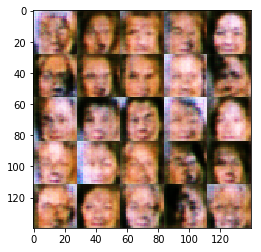

Epoch 1/1 ... Discriminator Loss: 1.3657... Generator Loss: 0.7241
Epoch 1/1 ... Discriminator Loss: 1.3434... Generator Loss: 0.8702
Epoch 1/1 ... Discriminator Loss: 1.2425... Generator Loss: 0.8851
Epoch 1/1 ... Discriminator Loss: 1.3032... Generator Loss: 0.8586
Epoch 1/1 ... Discriminator Loss: 1.4637... Generator Loss: 0.9580
Epoch 1/1 ... Discriminator Loss: 1.3679... Generator Loss: 0.7544
Epoch 1/1 ... Discriminator Loss: 1.4525... Generator Loss: 0.8743
Epoch 1/1 ... Discriminator Loss: 1.3503... Generator Loss: 0.7543
Epoch 1/1 ... Discriminator Loss: 1.3295... Generator Loss: 0.8704
Epoch 1/1 ... Discriminator Loss: 1.2946... Generator Loss: 0.8322


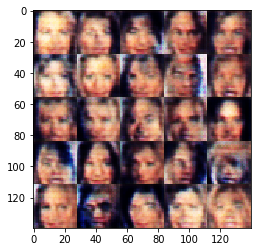

Epoch 1/1 ... Discriminator Loss: 1.4908... Generator Loss: 0.7470
Epoch 1/1 ... Discriminator Loss: 1.3681... Generator Loss: 0.8728
Epoch 1/1 ... Discriminator Loss: 1.3206... Generator Loss: 0.8419
Epoch 1/1 ... Discriminator Loss: 1.2814... Generator Loss: 0.9606
Epoch 1/1 ... Discriminator Loss: 1.3191... Generator Loss: 0.7525
Epoch 1/1 ... Discriminator Loss: 1.4341... Generator Loss: 0.8095
Epoch 1/1 ... Discriminator Loss: 1.3196... Generator Loss: 0.8098
Epoch 1/1 ... Discriminator Loss: 1.3774... Generator Loss: 0.8020
Epoch 1/1 ... Discriminator Loss: 1.3679... Generator Loss: 0.8461
Epoch 1/1 ... Discriminator Loss: 1.3905... Generator Loss: 0.8661


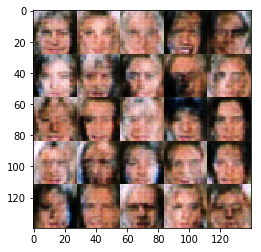

Epoch 1/1 ... Discriminator Loss: 1.3176... Generator Loss: 0.8191
Epoch 1/1 ... Discriminator Loss: 1.3955... Generator Loss: 0.8291
Epoch 1/1 ... Discriminator Loss: 1.3243... Generator Loss: 0.8501
Epoch 1/1 ... Discriminator Loss: 1.3586... Generator Loss: 0.8296
Epoch 1/1 ... Discriminator Loss: 1.3495... Generator Loss: 0.8345
Epoch 1/1 ... Discriminator Loss: 1.2887... Generator Loss: 0.8721
Epoch 1/1 ... Discriminator Loss: 1.3163... Generator Loss: 0.7870
Epoch 1/1 ... Discriminator Loss: 1.2087... Generator Loss: 0.9240
Epoch 1/1 ... Discriminator Loss: 1.3213... Generator Loss: 0.7895
Epoch 1/1 ... Discriminator Loss: 1.3644... Generator Loss: 0.7988


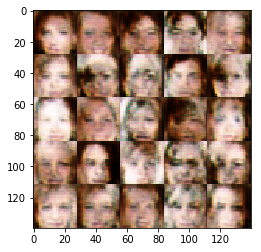

Epoch 1/1 ... Discriminator Loss: 1.3991... Generator Loss: 0.7700
Epoch 1/1 ... Discriminator Loss: 1.4119... Generator Loss: 0.7521
Epoch 1/1 ... Discriminator Loss: 1.2624... Generator Loss: 0.8613
Epoch 1/1 ... Discriminator Loss: 1.3655... Generator Loss: 0.7963
Epoch 1/1 ... Discriminator Loss: 1.3343... Generator Loss: 0.8240
Epoch 1/1 ... Discriminator Loss: 1.3835... Generator Loss: 0.8091
Epoch 1/1 ... Discriminator Loss: 1.4430... Generator Loss: 0.7476
Epoch 1/1 ... Discriminator Loss: 1.3836... Generator Loss: 0.7333
Epoch 1/1 ... Discriminator Loss: 1.4310... Generator Loss: 0.8003
Epoch 1/1 ... Discriminator Loss: 1.4474... Generator Loss: 0.7471


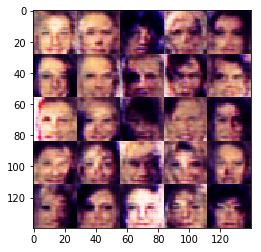

Epoch 1/1 ... Discriminator Loss: 1.3482... Generator Loss: 0.7866
Epoch 1/1 ... Discriminator Loss: 1.5109... Generator Loss: 0.7335
Epoch 1/1 ... Discriminator Loss: 1.4049... Generator Loss: 0.7393
Epoch 1/1 ... Discriminator Loss: 1.3562... Generator Loss: 0.8388
Epoch 1/1 ... Discriminator Loss: 1.4424... Generator Loss: 0.7720
Epoch 1/1 ... Discriminator Loss: 1.4088... Generator Loss: 0.8137
Epoch 1/1 ... Discriminator Loss: 1.3512... Generator Loss: 0.8762
Epoch 1/1 ... Discriminator Loss: 1.4063... Generator Loss: 0.7388
Epoch 1/1 ... Discriminator Loss: 1.3393... Generator Loss: 0.8853
Epoch 1/1 ... Discriminator Loss: 1.2828... Generator Loss: 0.8874


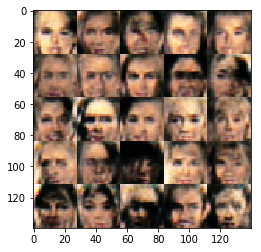

Epoch 1/1 ... Discriminator Loss: 1.3257... Generator Loss: 0.8253
Epoch 1/1 ... Discriminator Loss: 1.4084... Generator Loss: 0.7868
Epoch 1/1 ... Discriminator Loss: 1.2914... Generator Loss: 0.8255
Epoch 1/1 ... Discriminator Loss: 1.3560... Generator Loss: 0.8007
Epoch 1/1 ... Discriminator Loss: 1.4208... Generator Loss: 0.7935
Epoch 1/1 ... Discriminator Loss: 1.4046... Generator Loss: 0.7308
Epoch 1/1 ... Discriminator Loss: 1.3831... Generator Loss: 0.8124
Epoch 1/1 ... Discriminator Loss: 1.3424... Generator Loss: 0.8095
Epoch 1/1 ... Discriminator Loss: 1.3950... Generator Loss: 0.8782
Epoch 1/1 ... Discriminator Loss: 1.3099... Generator Loss: 0.8234


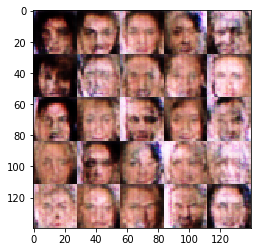

Epoch 1/1 ... Discriminator Loss: 1.3280... Generator Loss: 0.8554
Epoch 1/1 ... Discriminator Loss: 1.2892... Generator Loss: 0.8648
Epoch 1/1 ... Discriminator Loss: 1.4215... Generator Loss: 0.8382
Epoch 1/1 ... Discriminator Loss: 1.2795... Generator Loss: 0.8320
Epoch 1/1 ... Discriminator Loss: 1.3868... Generator Loss: 0.7925
Epoch 1/1 ... Discriminator Loss: 1.4027... Generator Loss: 0.7808
Epoch 1/1 ... Discriminator Loss: 1.3620... Generator Loss: 0.8165
Epoch 1/1 ... Discriminator Loss: 1.4051... Generator Loss: 0.7678
Epoch 1/1 ... Discriminator Loss: 1.4032... Generator Loss: 0.8013
Epoch 1/1 ... Discriminator Loss: 1.2305... Generator Loss: 0.8649


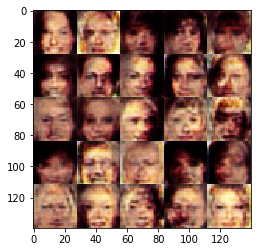

Epoch 1/1 ... Discriminator Loss: 1.3882... Generator Loss: 0.8894
Epoch 1/1 ... Discriminator Loss: 1.3770... Generator Loss: 0.7838
Epoch 1/1 ... Discriminator Loss: 1.3491... Generator Loss: 0.7644
Epoch 1/1 ... Discriminator Loss: 1.3302... Generator Loss: 0.8115
Epoch 1/1 ... Discriminator Loss: 1.3330... Generator Loss: 0.8530
Epoch 1/1 ... Discriminator Loss: 1.3007... Generator Loss: 0.7944
Epoch 1/1 ... Discriminator Loss: 1.3209... Generator Loss: 0.7543
Epoch 1/1 ... Discriminator Loss: 1.4118... Generator Loss: 0.8281
Epoch 1/1 ... Discriminator Loss: 1.3407... Generator Loss: 0.7868
Epoch 1/1 ... Discriminator Loss: 1.3706... Generator Loss: 0.8081


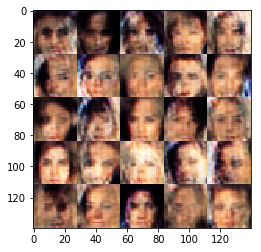

Epoch 1/1 ... Discriminator Loss: 1.4283... Generator Loss: 0.8048
Epoch 1/1 ... Discriminator Loss: 1.3616... Generator Loss: 0.8426
Epoch 1/1 ... Discriminator Loss: 1.3987... Generator Loss: 0.8120
Epoch 1/1 ... Discriminator Loss: 1.4266... Generator Loss: 0.7647
Epoch 1/1 ... Discriminator Loss: 1.4109... Generator Loss: 0.8019
Epoch 1/1 ... Discriminator Loss: 1.3799... Generator Loss: 0.8320
Epoch 1/1 ... Discriminator Loss: 1.2762... Generator Loss: 0.7846
Epoch 1/1 ... Discriminator Loss: 1.4949... Generator Loss: 0.8075
Epoch 1/1 ... Discriminator Loss: 1.3603... Generator Loss: 0.8582
Epoch 1/1 ... Discriminator Loss: 1.3796... Generator Loss: 0.8403


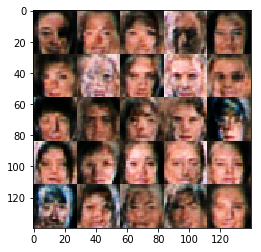

Epoch 1/1 ... Discriminator Loss: 1.4246... Generator Loss: 0.7694
Epoch 1/1 ... Discriminator Loss: 1.2978... Generator Loss: 0.7967
Epoch 1/1 ... Discriminator Loss: 1.3989... Generator Loss: 0.8328
Epoch 1/1 ... Discriminator Loss: 1.3372... Generator Loss: 0.7929
Epoch 1/1 ... Discriminator Loss: 1.3506... Generator Loss: 0.8214
Epoch 1/1 ... Discriminator Loss: 1.3991... Generator Loss: 0.8256
Epoch 1/1 ... Discriminator Loss: 1.3192... Generator Loss: 0.8631
Epoch 1/1 ... Discriminator Loss: 1.3645... Generator Loss: 0.7794
Epoch 1/1 ... Discriminator Loss: 1.4085... Generator Loss: 0.7568


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.